# Corona genomics tutorial

> Last updated: April 12, 2020; v 0.2.2

> Note: This is a new tutorial, whipped together from a number of recent, non-peer reviewed papers, based on data that is not always very well documented. To boot, all of this had to be done in a bit of a hurry. Any mistakes you may spot, - data, code, or text, let me know!

> where you can reach me: hendrik-jan.megens --at-- wur.nl

### First things first: run the next two code cells

Before starting analysis through the notebook, you will have to make sure that you are using the `ABG30306_Genomics/AandA` kernel that you have used for `Module 2`. In case you do not have that kernel installed, you have to first run the first code cell. You only need to do this once. Once the kernel is there, you should be able to find it from available kernels. 


>Running the cells can be done by activating the cell by pressing on it using your mouse, then either click the `>|Run` button at the top menu, or, alternatively, use a combination of keyboard keys `SHIFT`+`ENTER`. Note that everything in the notebook is done in different cells, either 'code cells' or 'text cells'. The text cells are in fact also in a sort of 'code' (a markup code called '[Markdown](https://en.wikipedia.org/wiki/Markdown)', similar to what is used e.g. in Wikipedia). Should you see a small icon of a 'missing picture' in the text, double-click the text cell, and simply re-run it. If you double-click a cell, you will in fact notice that the underlying 'markdown text' will appear. Again, you can just run that text-cell to render it nicely. 

>Make sure that you have a 'kernel' running, even if at first it is not the desired kernel for this exercise. Go to the menu at the top, and choose `Kernel` --> `Change Kernel`. Once you have run the code in the FIRST code cell below, you should see as an option to choose the kernel named `ABG30306_Genomics/AandA`. If you don't see that, then first choose the generic kernel `python 3.7.1`, then run the first code cell again. **You may need to reload the webpage for the change to take effect (`F5`, or the reload button on your browser). **

>If you managed to select the correct kernel, you should see the kernel name `ABG30306_Genomics/AandA` in top-right corner of your screen (if you still see e.g. `python 3.7.1`, then something went wrong and you need to try the previous procedure again - don't forget to reload your webbrowser, either using the reload button or the `F5` key!). 

If the correct kernel, `ABG30306_Genomics/AandA`, is loaded, you can proceed with the subsequent two code cells (they will do some additional housekeeping), and then the exercise. 

**NOTE:** you need to run code cells 2 and 3 every time you restart your server or your kernel (i.e., whenever you start a new session.  

In [ ]:
%%bash
# do this first, only needed once
# once completed, change the kernel as described above.
mkdir -p ~/.local/share/jupyter/kernels/AandA
cp /cm/shared/apps/SHARED/conda_envs/ABG30306_Genomics/kernels/AandA/* ~/.local/share/jupyter/kernels/AandA/

In [1]:
# import some libraries
import matplotlib.pyplot as plt
from Bio import SeqIO
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# Set some variables
# and copy data to the present working directory
import os
mypwd = os.getcwd()
datadir = '/lustre/shared/ABG30306/Corona_project/data/'
os.environ['DATADIR'] = datadir
! rsync -av /lustre/shared/ABG30306/Corona_project/files/* $PWD

sending incremental file list
MN908947_3.fasta
MN908947_3.fasta.fai
MN908947_3.gb
PC00101P_L1_downsampled.fastq
sam_to_fq.py
figures/
figures/MN908947_3_annotation.png

sent 132,974,770 bytes  received 142 bytes  88,649,941.33 bytes/sec
total size is 132,941,835  speedup is 1.00


## Background 

**Learning objectives:**

*At the end of this tutorial, students will be able to:*
* recognize the potential for long read sequence data to identify and quantify DNA and RNA in living processes
* apply generic genome databases and literature resources to identify and download reference data
* apply generic methods for mapping Nanopore sequence reads to study biological properties of SARS-CoV-2

Among the major breakthroughs of the past years were the introduction of new sequencing technologies, the most important ones:

* Illumina (Sequencing by Synthesis, high quality but short, paired reads
* Pacific BioSciences (direct sequencing, long reads, sequencing by real-time analysis of polymerase-based incorporation of fluorescent nucleotides)
* Oxford Nanopore (direct DNA molecule sequencing, long reads, measuring base-specific current alterations as molecule is drawn through a pore)

The long molecule sequencing technologies have plaid a specific role in understanding the replication cycle of the virus, in much the same way that these technologies are currently revolutionizing Genomics everywhere - cheaper, better characterization of entire genomes (genome assembly), and better characterization of transcriptomes, all by virtue of directly sequencing the molecules of interest, potentially from start to end. In this tutorial we are focussing mostly on Nanopore long reads. In part because one of the key properties of this sequencing technologies is that it is now so widely adopted. In its basic form, Nanopore sequencing is extremely portable. Furthermore, it can generate extremely short turnaround times, from sample prep to sequence data in a matter of hours. Compared to e.g. Illumina sequencing, which typically requires at least several days to result. 

## Exploring the 'transcriptome' of SARS-CoV-2

In this short tutorial, we will investigate how Nanopore long read sequencing has been applied in understanding some of the key properties of COVID-19/SARS-CoV-2. One area where long read, direct RNA molecule, sequencing has made a tremendous impact is in understanding how the RNA genome (gRNA) is expressed in the host cells.

To provide the necessary background to interpret results in the tutorial, and to get a better understanding of the 
the molecular biology and genomics of Corona/SARS like viruses, we recommend the following paper and book chapter:

* [Masters, 2006](https://www.sciencedirect.com/science/article/pii/S0065352706660053?via%3Dihub). Not a recent text, but there's loads of information here. In fact, so much you may feel that this is way more than you need. but Just focus on some of the figures and tables (and their legends), they should provide most of the necessary background.
* [Fehr and Perlman, 2015 (Chapter 1 of Maier et al., Eds, Coronaviruses, Methods and Protocols)](https://link.springer.com/content/pdf/10.1007%2F978-1-4939-2438-7.pdf). Slightly updated compared to the Masters, 2006 paper, and more readable. While it still has sufficient detail, it lacks good figures to understand some of the fundamentals of replication and transcription.

We recommend that you read Fehr and Perlman, 2015 (only first Chapter of the book!), but as you read that, consult the figures and figure legends of Masters, 2006.

The first part of the tutorial is mostly based on these two papers:

* Kim et al., 2020: https://www.biorxiv.org/content/10.1101/2020.03.12.988865v2.full.pdf
* Taiaroa et al., 2020: https://www.biorxiv.org/content/10.1101/2020.03.05.976167v2.full.pdf

From **Kim et al.**, study the abstract, Figures 1 and 2, and (STAR) Methods until (not including) "*DNBseq RNA sequencing*". 

From **Taiaroa et al.**, study the abstract, Figure 1, Supplementary Figures 3a, 4, and 7a, and Methods section (especially the definition of the Leader Sequence). 

The data used for the tutorial is from Kim et al, and can be found [here](https://osf.io/8f6n9/). The data retrieved was in the 'NanoporeDRS/Vero-Infected' directory. *The data does not need to be downloaded again, it is on the Anunna server for you to use.*

In the tutorial we will try to replicate a number of steps in the Taiaroa et al. paper, but the data did not lend itself for that very well, most likely due to limited sequence coverage of reads that mapped properly to the reference. The Kim et al. paper however turned out to have excellent data to support not only their own findings, but also the ones from Taiaroa et al. as well. 

The reference genome we will use is from the first complete SARS-CoV-2 sequence published:
* https://www.ebi.ac.uk/ena/data/view/MN908947

* https://www.ncbi.nlm.nih.gov/nuccore/MN908947.3?report=genbank

(double click cell, then `>|Run` again, if you don't see image below)
<img src="figures/MN908947_3_annotation.png" alt="fig1" style="width: 700px;"/>

Download the Genbank report for `MN908947.3`.

> **Question 1a:** How many open reading frames (ORFs) are found in the SARS-CoV-2 genome? 

> **Question 1b:** Which is the longest, and how many bases is it? 

> **Question 1c:** How long is ORF2? How many AAs does the peptide have? 

> **Question 1d:** According to Kim et al., is the last ORF expressed?

> **Question 1e:** What is the feature at the very 3' end?

Next we will start investigating and analyzing the data from Kim et al. Before starting analysis through the notebook, you will have to make sure that you are using the `ABG30306_Genomics/AandA` kernel. And furthermore, you need to run the first two code cells, at the start of the notebook, every time you restart your server or your kernel.  

First thing we will do is look at the contents of the sequence data. To do that we will look at the first 8 lines, and we will investigate how many sequences there are in total:

In [3]:
# Show first two sequences
! head -8 $DATADIR/VeroInf24h.all.fastq
! echo "Number of sequences:"
! grep 'sampleid=vero-infected' $DATADIR/VeroInf24h.all.fastq | wc -l

@574e83d7-f2ce-40b7-8e5a-68190e8c041d runid=90bfe2e3c6c56327d64dd1e78bc48842ade46dc7 sampleid=vero-infected read=100 ch=272 start_time=2020-02-21T21:57:32Z
AGAGUGUUAGAGGUACAUAGUACUUUUAAAAGAACCUUGCUUUGGAACAUACGAGGGCUGUUACCAUCACACCUUAGCUGAUAACAAAUUUGCACUGACUUGCUUUAGCACUCAAUUGCUUCUUGUGUCUUGUCCUGAUGUGCAAACACAUCAGUUACGUGCCAGAUCAGUUCACCUAAACUGUUCAAUCAGACAAGAGGAAGUCAAGAACUUUACUCUCCAAAUUUUUAUUGUUGCGGCAAAACAGUGUUUCAUAACACUCGUUCACACUCAUAGAAAGACAGAAUGAUUGAACUUUCAUUAAUUGACUUCUAUUUGUGCUUUUAGCCUUUCUGCUAUAUUCCUUGUUUUAAUUAUGCUUAUUAUCUUUGGUUUUCUUGAACUGCAAGAUCAAUGAAACUUGUCACGCCUAAACGAACAUGAAAUUUCUUGUUUUCUUUAGGAAUACUUCAACUGUAGCUGCAUUUCACCAAGAAUGUAGUUUCAAGUUAUGUACUCAUCAACCAUAUGUAGUUGAUGACCCGUGUCCUAUCACAUCUUCUAUUCUAAAUGGUUAUUAGAGUAGGAGCUAGAAAAUCAGCACCUUUAAUUGAAUUGUGCGUGGAUGAGGCUGGUCUAAAUCACCCAUUCAGUCAUGAUAAGUAAUAUUAUACAGUUUCCUGUUCACCUUUUACAAUUAAUUGCCAGGAACCUAAAUUGGGAAGUCUUGUAGUGCGUUGUUCGCUCAUGAAGACUUUUAGAGUAUCAUGACGUUCGUGUUGUUUUAGAUUCAUCUAAAACGAACAAACUAAAAAAUGUCUGAUAAUGGACCCCAAAAUCAGCGAAAUGCACCCGCAUUACGUUG

> **Question 2a:** How many sequences are displayed in the results above?


> **Question 2b:** Is this DNA sequence or RNA sequence data? Looking at the sequencing procedure and the research question, why does this make sense?

> **Question 2c:** According to Figure 1 of Kim et al., when sequencing complete RNA molecules, which specific homopolymer is to be expected at the 3' end of the Nanopore sequences? Do you observe this? (take into account that Nanopore sequence data is 'noisy', so some sequence mistakes can occur).

> **Question 2d:** How many sequences are there in total in this sequence file?


As above, and in the rest of the tutorial, we will apply approaches you have seen before (for the most part), notably in the Assembly and Annotation tutorial, to demonstrate the general application of sequence-based information. The Next step is to generate a sequence-length distribution, very much as you have done before. For the Assembly and Annotation tutorial, having long sequences was vital for a good genome assembly. But now we are not doing a genome assembly, but rather are looking at 'expressed' RNA molecules from SARS-CoV-2. The code, however, is identical (in fact, a few lines of code had to be removed, that was it):

In [4]:
# this part can take up to a few minutes
lengths = list()                                             # this list will store all the lengths
fastqfile = open(datadir+"/VeroInf24h.all.fastq" , 'r')      # open the fastq file with nanopore data

for record in SeqIO.parse(fastqfile, "fastq"):               # loop through all sequences
    lengths.append(len(record.seq))                          # add sequence length to list

fastqfile.close()                                            # close the fastqfile

print('total bases, summed up from all reads: {:,}'.format(np.sum(lengths)))  # print total number bases

total bases, summed up from all reads: 1,955,800,462


> **Question 3:** What is average sequence coverage, assuming that all reads indeed will align to the SARS-CoV-2 reference genome?

And plotting the lengths in the histogram. Again, mostly the same compared to what you've seen before, although we are now scaling the lengths of the reads to make a more presentable histogram. 

Text(0, 0.5, 'Total sequence in length category')

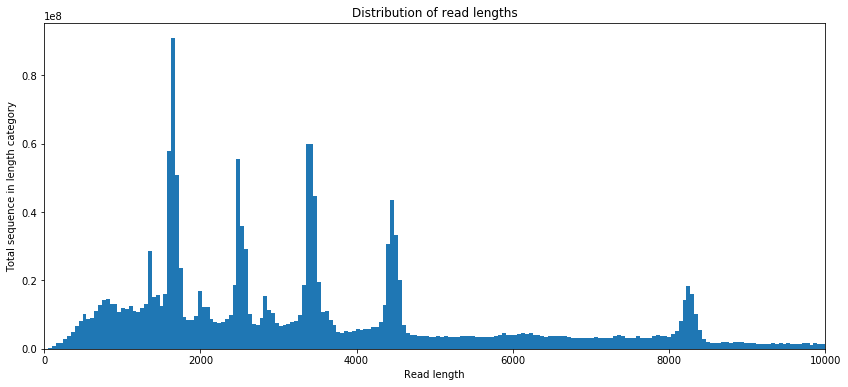

In [5]:
# and some simple plotting of the histogram
plt.figure(figsize=(14, 6))
plt.hist(lengths,weights=lengths,bins=1000)                   # plot the histogram
plt.xlim([0,10000])
plt.title('Distribution of read lengths')
plt.xlabel('Read length')
plt.ylabel('Total sequence in length category')

You will notice a distince 'peaky-ness' of the distribution of reads.

> **Question 4:** How do you explain this distribution of read lengths?

In both the papers of Kim et al. and Taiaroa et al., you may have notice they've used Minimap2 to align Nanopore reads to the reference genome. You've previously done the same, for *Botrytis aclada* PacBio reads in Module 2, remember!? So, this is a tool that should be somewhat familiar to you. Let's apply it to our current problem:

In [6]:
# do the mapping - lots of data to map, will take a few minutes
! minimap2 -a -x map-ont --secondary=no MN908947_3.fasta $DATADIR/VeroInf24h.all.fastq | samtools view -S -b - >mapped_to_MN908947.unsorted.bam

[M::mm_idx_gen::0.006*0.80] collected minimizers
[M::mm_idx_gen::0.007*1.30] sorted minimizers
[M::main::0.007*1.30] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.008*1.28] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.008*1.27] distinct minimizers: 5587 (99.93% are singletons); average occurrences: 1.004; average spacing: 5.332
[M::worker_pipeline::87.789*2.59] mapped 219860 sequences
[M::worker_pipeline::145.092*2.56] mapped 219851 sequences
[M::worker_pipeline::202.256*2.54] mapped 235087 sequences
[M::worker_pipeline::241.172*2.32] mapped 204881 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -a -x map-ont --secondary=no MN908947_3.fasta /lustre/shared/ABG30306/Corona_project/data//VeroInf24h.all.fastq
[M::main] Real time: 241.174 sec; CPU: 558.780 sec; Peak RSS: 2.784 GB


The resulting alignment file (BAM) is quite big; check it by running the next line of code, it should be at the top of your list:

In [7]:
# show files in your present working dir
# sorted by time created, newest first
! ls -lth | head

total 2.2G
-rw-r--r-- 1 megen002 domain users 2.1G Apr  8 19:36 mapped_to_MN908947.unsorted.bam
-rw-r--r-- 1 megen002 domain users  59K Apr  8 19:36 Corona_Nanopore_tutorial-v0_2_1.ipynb
-rw-r--r-- 1 megen002 domain users   26 Apr  5 14:54 MN908947_3.fasta.fai
-rw-r--r-- 1 megen002 domain users 127M Apr  5 12:06 PC00101P_L1_downsampled.fastq
-rw-r--r-- 1 megen002 domain users  594 Apr  5 12:05 sam_to_fq.py
-rw-r--r-- 1 megen002 domain users  30K Apr  5 12:05 MN908947_3.fasta
-rw-r--r-- 1 megen002 domain users  56K Apr  5 12:05 MN908947_3.gb
drwxr-xr-x 2 megen002 domain users 4.0K Apr  4 16:31 figures


And, you may recognize the drill by now, the minimap2 outcome is an alignment file in BAM format, unsorted. So it need sorting, and subsequent indexing:

In [8]:
# sort and index bam file - impressive alignment, will take a few minutes
! samtools sort mapped_to_MN908947.unsorted.bam -o mapped_to_MN908947.sorted.bam
! samtools index mapped_to_MN908947.sorted.bam
print("Housekeeping: remove the unsorted BAM to save space!")
! rm *.sorted.bam.tmp.*.bam            # really just in case samtools sort does not complete correctly
                                       # don't worry if throws an error, that just means sorting went ok.
! rm mapped_to_MN908947.unsorted.bam

[bam_sort_core] merging from 4 files and 1 in-memory blocks...
Housekeeping: remove the unsorted BAM to save space!
rm: cannot remove ‘*.sorted.bam.tmp.*.bam’: No such file or directory


Once this is done, we can produce coverage statistics for every base in the reference genome. We use a tool that you have not encountered before during the course, called 'bedtools'. [Bedtools](https://bedtools.readthedocs.io/en/latest/) is the 'Swiss army knife' for everything that you may need to do that involves intervals, such as annotated in .bed or .vcf files, but can also work on .bam files:

In [9]:
# Compute coverage - again, patience, takes a few minutes
! bedtools genomecov -ibam mapped_to_MN908947.sorted.bam -d >genomecoverage_all_aligned_reads.txt
print("Coverage calculation done!")

Coverage calculation done!


The output is a three-column file, that holds depth for every base. 

1. Column 1 is the name of the reference sequence (in this case, for every base, it is MN908947.3)
2. the second column is the position in the reference sequence, 
3. and the third base is the number of reads that are covering that position, or, simply, 'coverage'. 

Let's look at the first 10 lines of the output:

In [10]:
# first 10 lines
! head genomecoverage_all_aligned_reads.txt

MN908947.3	1	10
MN908947.3	2	20
MN908947.3	3	33
MN908947.3	4	47
MN908947.3	5	82
MN908947.3	6	97
MN908947.3	7	101
MN908947.3	8	121
MN908947.3	9	145
MN908947.3	10	186


Subsequently, we can plot the depth of coverage for every position. We do this by first reading in the three-column table, and then the seconde column is plotted against the third.

Text(0, 0.5, 'Depth of coverage')

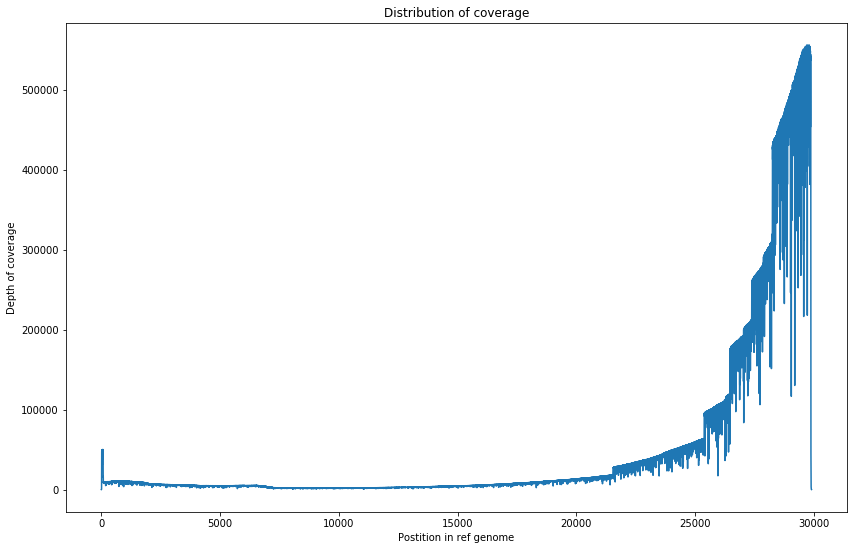

In [11]:
# read coverage file and plot
coverage = pd.read_csv('genomecoverage_all_aligned_reads.txt',sep='\t',header=None, names=['Ref', 'position','depth'],)
coverage.head()
plt.figure(figsize=(14, 9))
plt.plot(coverage.position, coverage.depth)
plt.title('Distribution of coverage')
plt.xlabel('Postition in ref genome')
plt.ylabel('Depth of coverage')
#plt.yscale('log')  # uncomment this line to make the vertical axis log scale

Repeat the previous code cell by uncommenting the last line of code (i.e. remove the `#`).

> **Question 5a:** What is the difference between the two Figures you made, with and without the last line of code active? Why would this be useful to do?

Compare the result to `Figure 2B` from Kim et al.

> **Question 5b:** What is the interpretation of the 'stepped' appearance of the distribution

In Taiaroa et al, the authors were looking for a similar 'stepped' distribution, but from their data it was less apparent compared to the Kim et al. data. To focus on complete mRNAs they selected only the sequenced molecules that contained the specific 'leader' sequence that should be at the start of each 'subgenome' RNA. 

In the next code cell we create a fasta file, with the file name `leader.fasta`, that contains the leader sequence, which we call `leader_seq`.

In [12]:
# leader sequence as described in Taiaroa et al
# write it to file: leader.fasta
leader = 'ACCUUCCCAGGUAACAAACCAACCAACUUUCGAUCUCUUGUAGAUCUGUUCUCUAAACGAAC'
print(len(leader))
leader_fh = open('leader.fasta', 'w')
leader_fh.write('>leader_seq\n')
leader_fh.write(leader)
leader_fh.close()

62


You can check that it worked by looking at the content of the new fasta file:

In [13]:
# show contents of 'leader.fasta'
! cat leader.fasta

>leader_seq
ACCUUCCCAGGUAACAAACCAACCAACUUUCGAUCUCUUGUAGAUCUGUUCUCUAAACGAAC

In the next step, we can map the leader sequence to the Nanopore sequence reads. Let's first just look at how the results look like, by aligning, then selecting only the ones that indeed did align to a leader seq (the third column of the [SAM/BAM](https://samtools.github.io/hts-specs/SAMv1.pdf) output contains the reference sequence name the Nanopore read mapped to). The fourth column of the SAM/BAM output, by the way, shows the position on the reference (we expect that to be close to zero in this case). If you want to get a good idea how well the leader sequence mapped you can have a look at column 6, which shows the CIGAR (**C**oncise **I**diosyncratic **G**apped **A**lignment **R**eport) string.

In [14]:
# map and show first lines
! minimap2 -a -x map-ont leader.fasta $DATADIR/VeroInf24h.all.fastq | grep leader_seq | head -5

[M::mm_idx_gen::0.005*0.71] collected minimizers
[M::mm_idx_gen::0.006*1.02] sorted minimizers
[M::main::0.006*1.02] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.006*1.02] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.006*1.02] distinct minimizers: 7 (100.00% are singletons); average occurrences: 1.000; average spacing: 8.857
@SQ	SN:leader_seq	LN:62
ccb244ef-e35b-4daf-a707-86ebf1d4a614	0	leader_seq	1	7	2S49M2I13M3648S	*	0	0	ATACCTTCCCAGGTAACAAACCAACCAACTTTCGATTTCTTGTAGATCTGTTCTCTCTAAACGAACTTATGTACTCATTCGTTCTAGAAGAGACAGGTACGTTAATAGTTATTAATAGCGTACTTCTTTTTGCTTTGTGGTATTCTTGCTGTCACACTAGCCATCCTTGTGCCGATTGTGTGCGTACTGCTGCAATTGTTAACGTGAGTCTGTAAAACCTTCTTCTACGTTTACTCGTGTTAAAAATTTGAAATTCTTCTAGAGTTCCTGATCTTCTGGTCTAAACGAACTAATATTATATATTAGTTTCTGTTTGAACTTTAATTTTTAGCCATAGGCAGATTCCAACGGTACTATTACCGTGAAGAGCTTAAAAGCTTTGAACGAATGGAACCTAGTAATAGGTTTCCTATTTCCATCGGATTTGTTTTTTACAATCTCGCCTATGCCAACAGGAATAGGTTTTTGTATAATTAAGTTAATTTCCTGGCTGTTATGG

We can therefore select only the reads in the SAM/BAM alignment file that were mapped to the leader sequence. Without having to save them seperately, we can simply pass every selected SAM line to a small utility script, `sam_to_fq.py`, that does the conversion on the fly (it simply takes column 1, the read name, column 10, the sequence, and column 11, the quality string and prints them out on separate lines). Just for your reference, the content of the script is below (you have copied the script to your present working directory already, by applying the second code cell).


```python
import sys

counter = 0
for line in sys.stdin:
    if not line.startswith('@'):
        elements = line.rstrip().split('\t')
        readname = elements[0]
        readseq = elements[9]
        readq = elements[10]
        sys.stdout.write("@{}\n{}\n+\n{}\n".format(readname, readseq,readq))
        counter += 1

sys.stderr.write("Number of sequences written: {}\n".format(counter))
```

So, here it goes, the selected sequences will be transferred to a fastq file called `contain_leader_seq.fq`:

In [15]:
# map and create fastq of sequences mapped to leader
! minimap2 -a -x map-ont leader.fasta $DATADIR/VeroInf24h.all.fastq | grep leader_seq | python sam_to_fq.py 1>contain_leader_seq.fq

[M::mm_idx_gen::0.004*0.92] collected minimizers
[M::mm_idx_gen::0.005*1.32] sorted minimizers
[M::main::0.005*1.32] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.005*1.31] mid_occ = 2
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.005*1.31] distinct minimizers: 7 (100.00% are singletons); average occurrences: 1.000; average spacing: 8.857
[M::worker_pipeline::11.614*2.24] mapped 219860 sequences
[M::worker_pipeline::17.327*2.44] mapped 219851 sequences
[M::worker_pipeline::24.928*2.56] mapped 235087 sequences
[M::worker_pipeline::28.906*2.51] mapped 204881 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -a -x map-ont leader.fasta /lustre/shared/ABG30306/Corona_project/data//VeroInf24h.all.fastq
[M::main] Real time: 28.907 sec; CPU: 72.575 sec; Peak RSS: 1.938 GB
Number of sequences written: 39718


How many sequences were selected this way? (run next code cell)

In [16]:
# how many sequences?
! cat contain_leader_seq.fq | grep '^@' | wc -l

39718


> **Question 6:** what percentage of all RNA reads in the dataset actually do contain a leader sequence?

Next up, we can do the same as before, map these selected reads, selected to contain the leader sequence, agains the reference genome.

In [17]:
# map, sort, index
! minimap2 -a -x map-ont --secondary=no MN908947_3.fasta contain_leader_seq.fq | samtools view -S -b - >mapped_wleader.unsorted.bam
! samtools sort mapped_wleader.unsorted.bam -o mapped_wleader.sorted.bam
! samtools index mapped_wleader.sorted.bam

[M::mm_idx_gen::0.010*0.62] collected minimizers
[M::mm_idx_gen::0.012*1.11] sorted minimizers
[M::main::0.012*1.11] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.013*1.10] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.013*1.10] distinct minimizers: 5587 (99.93% are singletons); average occurrences: 1.004; average spacing: 5.332
[M::worker_pipeline::25.421*2.22] mapped 39718 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -a -x map-ont --secondary=no MN908947_3.fasta contain_leader_seq.fq
[M::main] Real time: 25.423 sec; CPU: 56.547 sec; Peak RSS: 0.337 GB


Again, we will compute the genome coverage ...

In [18]:
# compute coverage
! bedtools genomecov -ibam mapped_wleader.sorted.bam -d >genomecov_wleader.txt
print("Done computing coverage!")

Done computing coverage!


... and again, we will plot the results

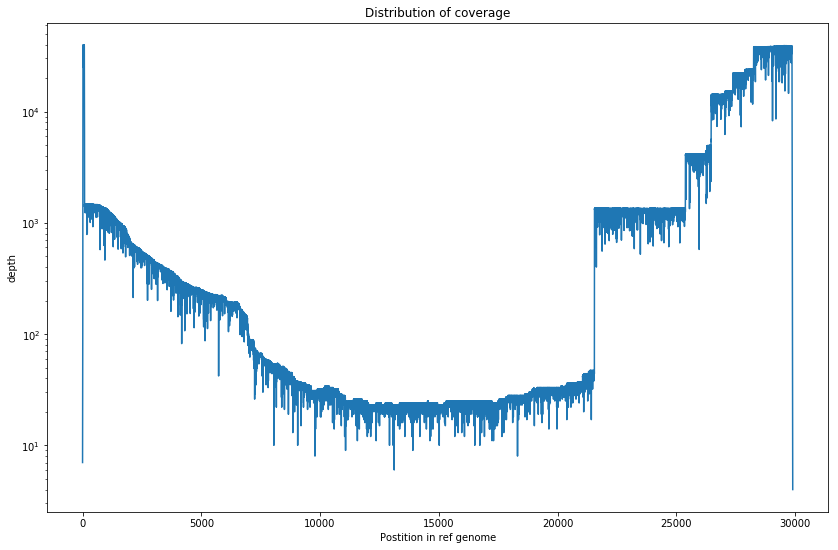

In [19]:
# read coverage and plot
coverage = pd.read_csv('genomecov_wleader.txt',sep='\t',header=None, names=['Ref', 'position','depth'],)
coverage.head()
plt.figure(figsize=(14, 9))
plt.plot(coverage.position, coverage.depth)
plt.title('Distribution of coverage')
plt.xlabel('Postition in ref genome')
plt.ylabel('depth')
plt.yscale('log')

Compare the result to Taiaroa et al., Supplementary Figure 7.

> **Question 7a:** Explain the difference in the coverage distribution compared to the previous coverage distribution you made (i.e. Question 5). 

> **Question 7b:** Identify the open reading frames.

Now download `mapped_wleader.sorted.bam` and `mapped_wleader.sorted.bam.bai` to your own computer, and start up `IGV`. For genome, upload the Genbank report for `MN908947.3` (see Question 1). IGV can detect both the sequence and the annotations directly, if the genbank report is used as reference genome (go to "Genomes" --> "Load Genome from File". 

Then also load the `mapped_wleader.sorted.bam` alignment file. You may notice that by default not many reads are show. The read depth can at places get far too high to display. IGV by default downsamples the reads to display. But because there is such a massive difference in read depth accross the SARS-CoV-2 genome, this does not work very well for especially ORF1. Go to "View" --> "Preferences" --> "Alignments" (which is one of the tabs) --> set the tick box for 'Downsample reads', and sampling window size to '50' and number of reads per window to '100'. Don't forget to 'Save'.

>**Question 8a:** Identify the ORFs and discrete transitions in read depth from your IGV genome browser.

>**Question 8b:** Zoom in on the junction between ORF8 and ORF9. What lies between these ORFs? 

>**Question 8c:** Do the RNA reads start before ORF9, or at the start/after ORF9? 

>**Question 8d:** Do all ORF9-spanning reads start at the same position? 

Finally we can again look at the distribution of read lengths. From 'eyeballing' the IGV alignments you will have noticed that the reads usually start and end at very similar positions. So, after only selecting the sequence reads that do contain the leader sequence, how does the length distribution look like?

17
total bases in all reads: 111,733,578
number of sequence reads > 29,000 bp: 17


Text(0, 0.5, 'bases in read length class')

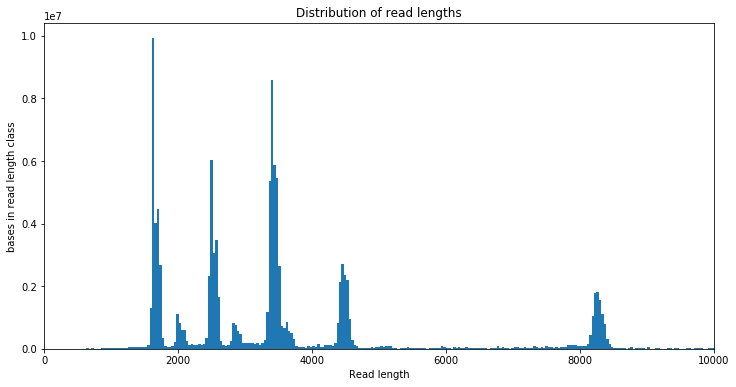

In [20]:
# create length distribution of sequence reads, and plot
lengths = list()                                     # this list will store all the lengths
fastqfile = open("contain_leader_seq.fq" , 'r')      # open the fastq file with nanopore data
counter = 0
for record in SeqIO.parse(fastqfile, "fastq"):       # loop through all sequences
    lengths.append(len(record.seq))                  # add sequence length to list
    if len(record.seq) > 29000:
        counter += 1
fastqfile.close()                                    # close the fastqfile

print(counter)
print('total bases in all reads: {:,}'.format(np.sum(lengths)))     # print total number bases
print('number of sequence reads > 29,000 bp: {}'.format(counter))           # print number reads >29kb


# and some simple plotting of the histogram
plt.figure(figsize=(12, 6))
plt.hist(lengths,weights=lengths,bins=1000)          # plot the histogram
plt.xlim([0,10000])
plt.title('Distribution of read lengths')
plt.xlabel('Read length')
plt.ylabel('bases in read length class')

> **Question 9a:** What is different and what is the same in the distribution of read lengths above, compared to the one you made earlier (i.e. Question 4)?

> **Question 9b:** Identify which reads belong to which ORF (see also Taiaroa et al., Supplementary Figure 3)

>> **Question 9c:** Why would it be of interest to specifically report the reads that are longer than 29,000 bp? (note: these are not in the figure, but are reported separatedly above.)


## COVID-19 Diagnostics - applying Nanopore reads. The short of it

Testing for COVID-19 has become a hotly debated issue - WHO states that the best strategy is to test as much as possible to be able to find infected people, even if asymptomatic, and isolate them until they recover/are no longer infectious. Most diagnostic tests simply provide a 'yes'/'no' answer regarding the presence of viral particles, usually from nose swabs or saliva. Such tests can, e.g., be based on PCR that use viral gRNA specific primers. 

However, it is of vital importance to also track the evolution of the virus. For that we can apply the sequence, and investigate whether mutations have arisen. Not only can give this insight in signs that the virus may start behaving differently, but it has also been an incredible tool to track the [migration of the virus accross the globe](https://nextstrain.org/ncov). Every day, new sequences are added to global databases, in a truly collaborative way that demonstrates the value of doing 'open science'. 

As with everything in dealing with this virus, time/speed are of the essence. While bureaucratic entities, set up to deal with emerging diseases no less, throughout many countries have dropped the ball, scientists are now racing to better understand the disease in every aspect that is relevant, delivering results in a matter of days. 

One sequence-based technology that is highly suited for quick turn-around of results, is Oxford Nanopore. Their technology can result in a complete viral gRNA sequence, from collection to final result, [in a mere 7 hours!](https://nanoporetech.com/about-us/news/novel-coronavirus-covid-19-information-and-updates). The sequencing itself only lasting about an hour.  

Much of these protocols were developed by a wider scientific community. Among the widely used procedures was developed by the [ARTIC network](https://artic.network/ncov-2019).

The procedures for diagnostics are very different from the data collection used for the first part of the tutorial, which is based on cultured and 'growing' virus particles. In stead, diagnostics is a much more messy afair, where virus particles, most no longer 'growing', but rather presented as excreted viral particles, have to be collected from the uppermost respiratory tract (nose, mouth). Sampling usually results in virus particles being together with a lot of host DNA/RNA. 

The protocol designed by the ARTIC network can be found here:

* https://www.protocols.io/view/ncov-2019-sequencing-protocol-bbmuik6w

There first is an RT-PCR step applying random hexamer primers. The virus genome is subsequently amplified by PCR by applying a coctail of primers that result in partially overlapping fragments. 

The primer set can be found here:

* https://github.com/artic-network/artic-ncov2019/blob/master/primer_schemes/nCoV-2019/V3/nCoV-2019.bed

We will look at a dataset from a patient in California that was sequenced by the Andersen lab at the Scripps Institute in California, USA. The description of the case and procedures for sequencing can be found here: 

* https://andersen-lab.com/secrets/data/hcov-19-genomics/

The dataset can be found here:
* https://www.ncbi.nlm.nih.gov/sra/SRX7949318[accn]


The amount of sequence data was definitely overkill for the purpose. To make the dataset a bit more manageable for this tutorial, the data was (randomly) downsampled, at around 1/30th.

The sequence data can be found in the file `PC00101P_L1_downsampled.fastq`. Let's have a quick look at the first three sequences:


In [21]:
# show first three sequences of fastq file
! head -12 PC00101P_L1_downsampled.fastq

@cec05f42-ab8e-41aa-b602-8e58753d1a3c
CATTGTACTTCGTTCAGTTACGTATTGCTGCCAACAACAACAAGGCCAAACTGTGCAGAAATCTGCTGCTGAGGCTTCCTAAGAAGCCTCGGCAAAAACAATACTGCCACTAAAGCATACAATGTAACACAAGCACGGCAGACGTGGTTAGTAAACCCAAGAGAATTTACGGGGACCAGGAACTAATCAGACAAGGAACGATTACAAACATTATTGCCGCAAATTGCTGTTGCCCCGGCGTAAGCGATTCTTCCGAATGTCGCGCATTGGCATGGAAGTCACACCTTCTTCGGGAACGTGGTTGACCTACACAGGTGCCATCAAATTGGATGACAAAGGTCATTCAAAGATCAAGTCATTAAAGGTTTTATACTTTTCCCAGGTAACTTAAGCCAATATAACTTTAGTCTTTGTAGATCTGTTCTCTAAACGACTTTAAAATCTGTGTGCAGCTGTCACTCGGCTGCGTGTTAGTGCACTCACGCAGGTATAATTAATAACTAATTACTGTCGTTGACAGGACGAGTAACTCGTCTATCTTCTGCAGGCTGCTTACGGTTTCGTCCGTGTTGCAGCCGATCATCAGCACATCTAGGTTTTGTCCGGAACGATGAAAGGTAAGATGGAGGCGCCCGTCCTGGTTTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTTTACAGGTTCGCGACGTGCTCGTACGTGGCTTTGGAGACTCCGTGAAGGAGGTCTTATCAGAGCACGTCAACATAAAAGATGGCACTTGTGGCTTAGTAGAAGTTGAAAAGGCGTTTTGCCTCAGCGGGCGGCCCTATGTGTTCATCAAACGTTCGGATACTCGAACTTTGCACCTCATGAATCATGTTATGGTTGAGCTGGTAGCAGAACTCAAGAAGGCATTGAGCCACGGTCGTAGTGGTGAGACACTTGGTGTCACTTGTCCCTCATGTGGGCGAAA

> **Question 10a:** Is the sequence data DNA or RNA

> **Question 10b:** Why does this make sense?

First let's have a look at the length distribution of the sequence reads:

total bases: 64,719,391


Text(0, 0.5, 'Read count')

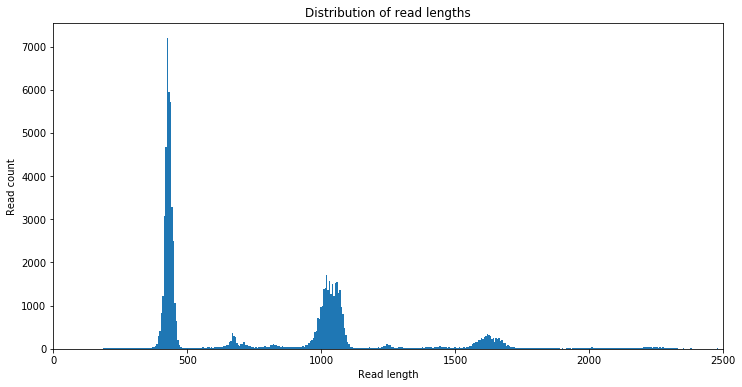

In [22]:
# create length distribution of sequence reads and plot
lengths = list()                                           # this list will store all the lengths
fastqfile = open("PC00101P_L1_downsampled.fastq" , 'r')    # open the fastq file with nanopore data
for record in SeqIO.parse(fastqfile, "fastq"):             # loop through all sequences
    lengths.append(len(record.seq))                        # add sequence length to list

fastqfile.close()                                          # close the fastqfile

print('total bases: {:,}'.format(np.sum(lengths)))           # print total number bases

# and some simple plotting of the histogram
plt.figure(figsize=(12, 6))
plt.hist(lengths,bins=1000)                                # plot the histogram
plt.xlim([0,2500])
plt.title('Distribution of read lengths')
plt.xlabel('Read length')
plt.ylabel('Read count')

> **Question 11a:** What is the size of the largest peak?

> **Question 11b:** Nanopore can sequence very long reads. Why then are the sequence reads here so short?

> **Question 11c:** When looking at the [primer set used](https://github.com/artic-network/artic-ncov2019/blob/master/primer_schemes/nCoV-2019/V3/nCoV-2019.bed), why does the read length of the highest peak make sense?

> **Question 11d:** Apart from the highest peak, there are addition peaks. What strikes you about the interval of each of these peaks? What could be the cause? (Hint: chimeric reads)

And, very similar to earlier parts of the exercise, we can now map to the reference genome...:


In [23]:
# map, sort, index
! minimap2 -a -x map-ont MN908947_3.fasta PC00101P_L1_downsampled.fastq | samtools view -S -b - >PC00101P.unsorted.bam
! samtools sort PC00101P.unsorted.bam -o PC00101P.sorted.bam
! samtools index PC00101P.sorted.bam

[M::mm_idx_gen::0.009*0.57] collected minimizers
[M::mm_idx_gen::0.011*0.98] sorted minimizers
[M::main::0.011*0.99] loaded/built the index for 1 target sequence(s)
[M::mm_mapopt_update::0.011*0.99] mid_occ = 3
[M::mm_idx_stat] kmer size: 15; skip: 10; is_hpc: 0; #seq: 1
[M::mm_idx_stat::0.012*0.99] distinct minimizers: 5587 (99.93% are singletons); average occurrences: 1.004; average spacing: 5.332
[M::worker_pipeline::12.231*2.07] mapped 79286 sequences
[M::main] Version: 2.17-r941
[M::main] CMD: minimap2 -a -x map-ont MN908947_3.fasta PC00101P_L1_downsampled.fastq
[M::main] Real time: 12.240 sec; CPU: 25.384 sec; Peak RSS: 0.200 GB


... and then, again, the same steps to compute coverage over the genome and plot it:

In [24]:
# compute coverage
! bedtools genomecov -ibam PC00101P.sorted.bam -d >PC00101P_coverage.txt
print("Coverage stats completed!")

Coverage stats completed!


Text(0, 0.5, 'depth')

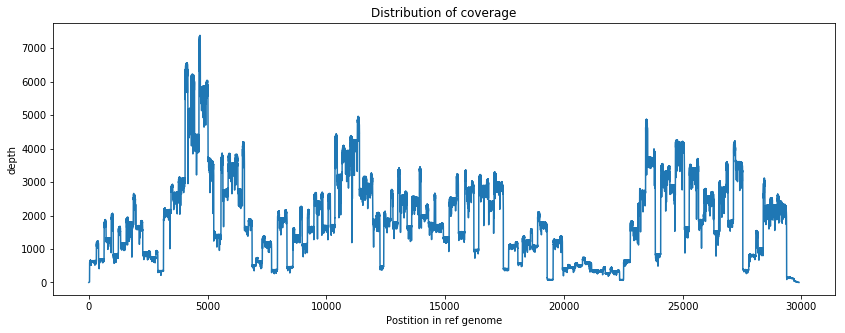

In [25]:
# read coverage stats and plot
coverage = pd.read_csv('PC00101P_coverage.txt',sep='\t',header=None, names=['Ref', 'position','depth'],)
coverage.head()
plt.figure(figsize=(14, 5))
plt.plot(coverage.position, coverage.depth)
plt.title('Distribution of coverage')
plt.xlabel('Postition in ref genome')
plt.ylabel('depth')

> **Question 12a**: The distribution has a very discrete, 'blocky' appearance. Why is it so 'blocky', and, on average, what is the size of each 'block'?

> **Question 12b:** Here too we see a big difference in coverage over the genome. It is however, not the same degree of difference in coverage compared to the direct RNA sequencing of the first part of the tutorial. What is the cause of the uneven distribution?

You will have noted that many of the tools got repeated time and again, and most were familiar from the Assembly and Annotation tutorial. As noted above, this is by design, since we want you to realize that much of the work on COVID-19/SARS-CoV-2 is rooted in the same molecular biology, bioinformatics, and genomics that you've encountered earlier in our Genomics cours. 

We hope this tutorial has been a good introduction and motivation for the next and final phase of the Genomics course: the Corona literature subjects.
